# New York City Taxi Fare Prediction

# Imports

In [1]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


spark = SparkSession.builder.appName("TaxiApp").config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()
plt.style.use('ggplot')

We will use Spark for data explorering and modeling

In [2]:
spark

Dataset can be downloaded form Kaggle: kaggle competitions download -c new-york-city-taxi-fare-prediction <br>
I recommend concert csv file into parquet format. It really improves performance.


In [2]:
data = spark.read.parquet('/work/develop/datasets/new_york_taxi/train.parquet')

In [3]:
data.createOrReplaceTempView('NY_taxi')

# EDA
Number of rows

In [5]:
data.count()

55423856

Schema

In [6]:
data.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



min max values of target feature "fare_amount"

In [4]:
data.select(F.min('fare_amount').alias('min'), F.max('fare_amount').alias('max')).show()

+------+--------+
|   min|     max|
+------+--------+
|-300.0|93963.36|
+------+--------+



General statistical characteristics of fare amount

In [9]:
data.select('fare_amount').describe().toPandas()

,summary,fare_amount
0,count,55423856
1,mean,11.345045601656047
2,stddev,20.710832198232467
3,min,-300.0
4,max,93963.36


In [10]:
# quantiles
data.select('fare_amount').approxQuantile("fare_amount",[0.1, 0.25, 0.5, 0.75, 0.9], 0.01)

[4.9, 6.1, 8.5, 12.9, 20.0]

Let's get rid of outliers and will use only rows where "fare_amount" in range (0,100)

In [5]:
req = """
select * from NY_taxi
where fare_amount>0 and fare_amount<100
"""
data = spark.sql(req)
data.count()

55397123

Check NA vakues in filtered dataset

In [64]:
data.select([F.count(F.when(F.isnan(c),c)).alias(c) for c in data.columns]).show()

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|                0|               0|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



Fare amount distribution

<AxesSubplot:>

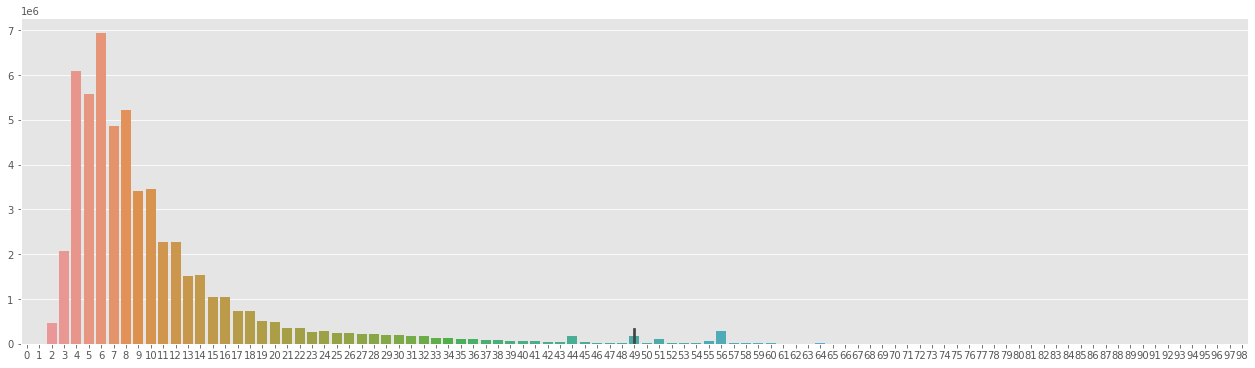

In [13]:
hist = data.select('fare_amount').rdd.flatMap(lambda x: x).histogram(100)
plt.figure(figsize=(22,6))
sns.barplot(list(map(lambda x: int(x), hist[0][:-1])), hist[1])

# Feature generation

### distance of trip

In [7]:
p = 0.017453292519943295
data = data.withColumn('distance', 0.6213712*12742*F.asin((0.5-F.cos((data['dropoff_latitude']-data['pickup_latitude'])*p)/2 +  
                                      F.cos(data['pickup_latitude']*p) * F.cos(data['dropoff_latitude']*p) * 
                                     (1-F.cos((data['dropoff_longitude']-data['pickup_longitude'])*p))/2)**0.5))

In [8]:
data.filter(data['distance']>0).count()

53820523

Get rid of rows where distance<0

In [9]:
data = data.filter(data['distance']>0)

### direction of a trip, from 180 to -180 degrees

In [10]:
data = data.withColumn('d_lon', data['pickup_longitude'] - data['dropoff_longitude'] )
data = data.withColumn('d_lat', data['pickup_latitude'] - data['dropoff_latitude'])
data = data.withColumn('lon_lat', (data['d_lon']**2 + data['d_lat']**2)**0.5)
data = data.withColumn('dev_ll', data['d_lat']/data['lon_lat'])

In [11]:
g =  180/np.pi
data = data.withColumn('direction', F.when(data['d_lon']>0, g*F.asin(data['dev_ll'])).
                               when((data['d_lon']<0) & (data['d_lat']>0), 180-g*F.asin(data['dev_ll'])).
                               when((data['d_lon']<0) & (data['d_lat']<0), -180 - g*F.asin(data['dev_ll'])).
                               otherwise(0))

# Modeling

In [34]:
# Train/Test splitting
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [36]:
continuous_variables = ['pickup_longitude',
                        'pickup_latitude',
                        'dropoff_longitude',
                        'dropoff_latitude',
                        'passenger_count',
                        'distance', 'direction']

In [37]:
assembler = VectorAssembler(
    inputCols=continuous_variables,
    outputCol='features')

## Train

In [38]:
trainingData = assembler.setHandleInvalid("skip").transform(trainingData)
testData = assembler.setHandleInvalid("skip").transform(testData)

In [39]:
# sample of feature vector
trainingData.limit(3).toPandas()['features'][0]

DenseVector([-73.9725, 40.7493, -73.9675, 40.7563, 1.0, 0.5453, -125.2774])

In [42]:
# Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol='features', labelCol='fare_amount')

# Model fitting
model = dt.fit(trainingData)

# Get oredictions
predictions = model.transform(testData)

In [49]:
print(model)

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_688a8feb1230, depth=5, numNodes=63, numFeatures=7


## Evaluation procedure

In [ ]:
evaluator = RegressionEvaluator(
    labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")

RMSE for train

In [51]:
rmse_train = evaluator.evaluate(model.transform(trainingData))
print("Train Root Mean Squared Error (RMSE) on test data = %g" % rmse_train)

Train Root Mean Squared Error (RMSE) on test data = 4.58237


RMSE for Test

In [47]:
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.58618


In [48]:
# Check feature importances
# Feature order: 'pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count', 'distance', 'direction'
model.featureImportances

SparseVector(7, {0: 0.0104, 1: 0.0048, 2: 0.0106, 3: 0.0015, 5: 0.9603, 6: 0.0124})

Comparing with naive hypothesis: always predict average value

In [52]:
# average fare_amount for test dataset
testData.select(F.mean(testData['fare_amount'])).show()

+------------------+
|  avg(fare_amount)|
+------------------+
|11.295716056322847|
+------------------+



In [56]:
avr = testData.agg(F.mean(testData['fare_amount']).alias("mean")).collect()[0]["mean"]
testData_upd = testData.withColumn('subt',((testData['fare_amount'] - avr)**2)**0.5)

# RMSE for naive hypothesis
testData_upd.agg(F.mean(testData_upd['subt'])).show()

+-----------------+
|        avg(subt)|
+-----------------+
|5.938217297379424|
+-----------------+



# Map visualization

In [12]:
# load image of NYC map
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('images/nyc_-74.3_-73.7_40.5_40.9.png')

In [13]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

In [14]:
# random selection 100000 rows from spark and convert into pandas frame
df = data.select('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude').limit(10000).toPandas()

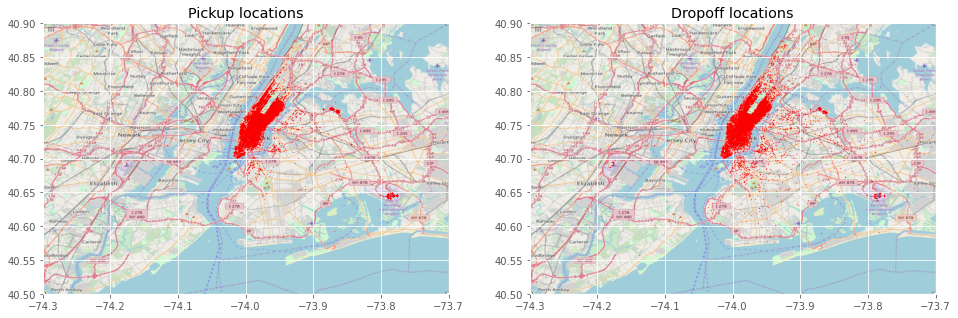

In [15]:
plot_on_map(df, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)